# How to use ProtNAff

This notebook will help you to understand how to use ProtNAff.

First to check if you made the installation a test on the `$PROTNAFF` env variable is made and if you have successfully installed `x3dna-dssr`.

In [1]:
%%bash 

if [[ -z "$PROTNAFF" ]]; then
    echo "You did not do the installation correctly, please refer to the INSTALLATION.md"
else
    if [[ -f "$PATH/x3dna-dssr" ]]; then
        echo "x3dna-dssr is not correctly installed."
    else
        echo "The installation seems correct."
    fi
fi

The installation seems correct.


### Creation of the NA-protein database

The first step is to create your `structures.json`. To do this you need a list of pdb id, for the instance we give you a small list.

In [26]:
!cd $PROTNAFF/example && cat pdbcode_test.list

1AQ3
1A34
1A1T
1A4T
1B23
1ASY
1AUD
1A9N


The creation of the database is done by:
`bash $PROTNAFF/create_database.sh [pdbcodes.list] ["dna"/"rna"]`

The steps performed by create_database.sh are the following:

* download all protein-NA structures from the PDB

* extract relevant information units on each structure (resolution, NA type, etc) and store it into one single easiliy-searchable json file.

* clean up each structure (add missing atoms, list incomplete nucleotides, list HETATM, etc)

* characterize the interface (sugar/phosphate/base - protein distances, water contacts, etc)

* use the 3DNA program [1] for NA structure description that gives exhaustive data in easily parsable Json format

* rearrange the data per nucleotide (eg. “nucl 5 to 15 make a stem-loop” → “nucl 5 is at position 1 in an 11-nucl stem-loop”)

[1] X-J Lu & WK Olson. 3DNA: a software package for the analysis, rebuilding and visualization of three‐dimensional nucleic acid structures. Nucleic Acids Research (2003) 31(17), 5108-21

With the list we provided you can run the `create_database.sh` script.

In [47]:
!mkdir -p $PROTNAFF/example/full_test
!cd $PROTNAFF/example/full_test && bash $PROTNAFF/create_database.sh $PROTNAFF/example/pdbcode_test.list rna

---------------------------- Download PDBs
-------------------------- check pdb
-------------------------- detect NA - protein interface 
---------------------------------  parse initial pdb
clean_rna.json dumped
--------------------------------- Fill-up missing atoms 
-------------------------------- apply 3dna


This command is creating a lot of files and folder where you run it, pay attention to where you want to have your results. To give you more details, the folders are:
* brutPDBs: the pdb files downloaded from the PDB (link);
* chainmodels: files about the chains in the pdb;
* cleanPDB: the pdb after several modifications;
* interface: the file about the interface between the protein and the NA;
* 3dna: the results of x3DNA.

But what you need to look at is the `structures.json`, and you can only use this one if you want. The next cell is looking at this file in details.

In [4]:
import json

structures = json.load(open("./full_test/structures.json"))

print("Structures :", list(structures.keys()))

print("For each structures you have information in those keys: {}".format(list(structures['1A9N'].keys())))

Structures : ['1A1T', '1A34', '1A4T', '1A9N', '1AQ3', '1ASY', '1AUD', '1B23']
For each structures you have information in those keys: ['NAprot_hb', 'NAprot_hb_sum', 'Nmodels', 'bptype', 'breaks', 'canonized', 'hetnames', 'interface_hetatoms', 'interface_protein', 'intraNA_hb', 'mapping', 'method', 'missing_atoms', 'nachains', 'protchains', 'resolution', 'sequence', 'ss', 'stacking']


If you want more informations on the content of `structures.json` please look at the paper (link).

### Requests to select (parts of) structures from the database

We created filters in python, but as the `.json` format is standard you can use the langage you want. Here we will use the filter to select part of RNA in contact with the protein and single-stranded.

The results will be print in a particular format, there is 3 information:
* The pdb id
* The RNA chain
* The list of ss nucleotides in contact, but be carreful, the numbers are the new numbers given by `create_database.sh`. If you want the numbers from the original pdb, you need to use the mapping in the `structures.json`

In [5]:
!cd $PROTNAFF/example/full_test
!python $PROTNAFF/create_benchmark/filters/ss_contact_filter.py structures.json

1A1T B []
1A34 B []
1A34 C []
1A4T A []
1A9N Q [6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18]
1A9N R [6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18]
1AQ3 R [7, 8, 9, 10]
1AQ3 S [6, 7, 8, 9]
1ASY R [26, 32, 33, 34, 35, 36, 37, 38, 72, 73, 74, 75]
1ASY S [26, 32, 33, 34, 35, 36, 37, 38, 72, 73, 74, 75]
1AUD B []
1B23 R [52, 71, 72, 73, 74]


### Creation of the fragment library

The next step is the creation of the fragment library. You need to use the `create_frag_library.sh` script in the folder where you runned the `create_database.sh` script.

Usage: `$PROTNAFF/create_frag_library.sh ["dna"/"rna"]`

The protein-bound NA structures are cut into fragments (here trinucleotides), that are pooled by sequence and clustered by pairwise RMSD.

To increase the number of fragments per sequence motif, the full structures are mutated T/U > C and G > A (ex. AGU becomes AAC), and the representative fragments after clustering are mutated back into the 8 possible "de-mutated" sequence (AAC => AAC, GAC, GGC, GGU, AGC, AGU, AAU, GAU).

To accelerate clustering, the fragments are first converted into ATTRACT's coarse-grained representation. The resulting clustering scheme is then applied to the all-atom fragments.

In [6]:
!cd $PROTNAFF/example/full_test
!bash $PROTNAFF/create_frag_library.sh rna

-------------------------------- mutate pdb files
-------------------------------- cut into fragments
create_template
-------------------------------- fragments clustering
create PDB fragments (for mutating) from clust1.0, CCC
Convert CCC library into coarse-grained
create PDB fragments (for mutating) from clust1.0, CCA
Convert CCA library into coarse-grained
create PDB fragments (for mutating) from clust1.0, CAC
Convert CAC library into coarse-grained
create PDB fragments (for mutating) from clust1.0, CAA
Convert CAA library into coarse-grained
create PDB fragments (for mutating) from clust1.0, ACC
Convert ACC library into coarse-grained
create PDB fragments (for mutating) from clust1.0, ACA
Convert ACA library into coarse-grained
create PDB fragments (for mutating) from clust1.0, AAC
Convert AAC library into coarse-grained
create PDB fragments (for mutating) from clust1.0, AAA
Convert AAA library into coarse-grained
-------------------------------- mutate back into all sequences
AAA


1A1T
1A34
1A4T
1A9N
1AQ3
1ASY
1AUD
1B23
CCC: 60 atoms, 223 structures
CCA: 62 atoms, 203 structures
CAC: 62 atoms, 197 structures
CAA: 64 atoms, 215 structures
ACC: 62 atoms, 256 structures
ACA: 64 atoms, 212 structures
AAC: 64 atoms, 272 structures
AAA: 66 atoms, 302 structures
Discarde redundant fragments of CCA with RMSD < 0.2 A toward another fragment
Discarde redundant fragments of CAC with RMSD < 0.2 A toward another fragment
Discarde redundant fragments of CAA with RMSD < 0.2 A toward another fragment
Discarde redundant fragments of ACC with RMSD < 0.2 A toward another fragment
Discarde redundant fragments of ACA with RMSD < 0.2 A toward another fragment
Discarde redundant fragments of AAC with RMSD < 0.2 A toward another fragment
Discarde redundant fragments of AAA with RMSD < 0.2 A toward another fragment
Discarde redundant fragments of CCC with RMSD < 0.2 A toward another fragment
-------------------------------------------------
Cluster ACC large (2.0 A); then tight (1.0 A)


For the moment the fragment libraries are only trinucleotides. But we are working on the creation of double-stranded libraries and if you need something specific you can ask us

### Test of the installation

To check if the installation is correct compare the graph that you will obtain with the one in `notebook_name`.

There is also a comparison of md5sum between the different `.json`

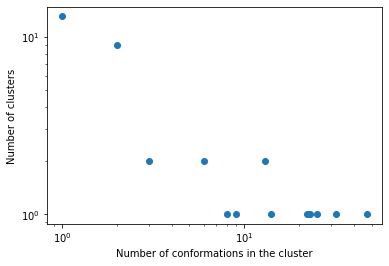

In [8]:
import matplotlib.pyplot as plt

with open("./full_test/trilib/AAA-dr0.2r-clust1.0") as ff:
    lines = ff.readlines()

res = {}
for line in lines:
    line = line.split(' ')
    len_line = len(line) - 4
    if len_line in res.keys():
        res[len_line] += 1
    else:
        res[len_line] = 1
        
fig, ax = plt.subplots()
ax.scatter(res.keys(), res.values())
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
ax.set_xscale("log")
ax.set_yscale("log")
ax.yaxis.set_tick_params(labelcolor="black")
ax.xaxis.set_tick_params(labelcolor="black")
plt.ylabel("Number of clusters", color="black")
plt.xlabel("Number of conformations in the cluster", color="black")
plt.show()